# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [705]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [706]:
import os
import pandas as pd
import skimage
import skimage.io
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm_notebook

In [354]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")
    
    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [355]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [237]:
attrs

Male     Asian     White     Black     Baby     Child      Youth  \
0        1.56835  -1.88904    1.7372 -0.929729  -1.4718  -0.19558  -0.835609   
1       0.169851 -0.982408  0.422709  -1.28218 -1.36006 -0.867002  -0.452293   
2       0.997749  -1.36419 -0.157377 -0.756447 -1.89183 -0.871526  -0.862893   
3        1.12272   -1.9978   1.91614  -2.51421 -2.58007  -1.40424  0.0575511   
4        1.07821   -2.0081   1.67621  -2.27806 -2.65185  -1.34841   0.649089   
...          ...       ...       ...       ...      ...       ...        ...   
13138  -0.205363 -0.202842  -1.23274  -1.40913 -1.80486  0.287268  -0.521815   
13139    1.95747  -2.47247  -1.30799 -0.671636 -1.96012 -0.838803   -1.36596   
13140 -0.0370013  -1.16415  0.228494  0.187503 -1.83647 -0.958412  -0.669697   
13141   0.282219 -0.396198   1.27047  -1.98121 -1.70294   -1.5072   -2.33072   
13142  0.0711971  -1.92884   2.12234  -1.89286 -2.04424 -0.313663 -0.0813693   

       Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0        -0.351468  -1.01253  -0.719593  ...  0.361738           1.16612   
1        -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2        0.0314447  -1.34152 -0.0900375  ...   1.54974           1.88475   
3      0.000195882  -1.27351   -1.43146  ...  0.567822         -0.176089   
4        0.0176564  -1.88911   -1.85721  ...  -1.46147         -0.955283   
...            ...       ...        ...  ...       ...               ...   
13138    -0.789165  -1.00812   0.531813  ... -0.867156         -0.879554   
13139     0.510448  -1.26219   0.418947  ...  -2.48729           2.60886   
13140     -0.48033  0.493433   -1.89315  ...  -1.93864          -0.49108   
13141    -0.295928   1.05662    -1.6137  ... -0.662101          -1.69213   
13142    -0.140593  -1.27778  -0.982043  ...  0.773205         -0.404315   

      Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0                    -1.16492         -1.13999     -2.37175        -1.29993   
1                     0.87416        -0.945431    -0.268649     -0.00624408   
2                   -0.999765         -1.35986     -1.91211        -1.09563   
3                     1.10812         -1.60094     -3.26461        0.813418   
4                    0.119113         -1.12818     -3.16105       0.0826804   
...                       ...              ...          ...             ...   
13138               -0.179497         0.323676     -2.18885        -1.16937   
13139                -0.95419         -1.59946     -1.23822        -1.18703   
13140                0.495067        -0.524767     -1.07373         0.11101   
13141                 1.28477         -0.80818    -0.710051        0.694621   
13142                -1.10077        -0.872605     -3.49063       -0.840752   

      Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0      -0.414682          -1.1449        0.694007        -0.826609  
1     -0.0304057        -0.480128         0.66676        -0.496559  
2       0.915126        -0.572332        0.144262        -0.841231  
3       0.308631        -0.848693        0.475941        -0.447025  
4      -0.439614        -0.359859       -0.760774        -0.410152  
...          ...              ...             ...              ...  
13138   0.924397        -0.217415       -0.414024        -0.495178  
13139    1.87413        -0.832614        0.152785        -0.554331  
13140   0.976262        -0.453027       -0.399981         -1.07866  
13141   0.936065          -0.7675         1.14693         -0.26094  
13142   0.532488        -0.946166       -0.232008         -1.25721  

[13143 rows x 73 columns]


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

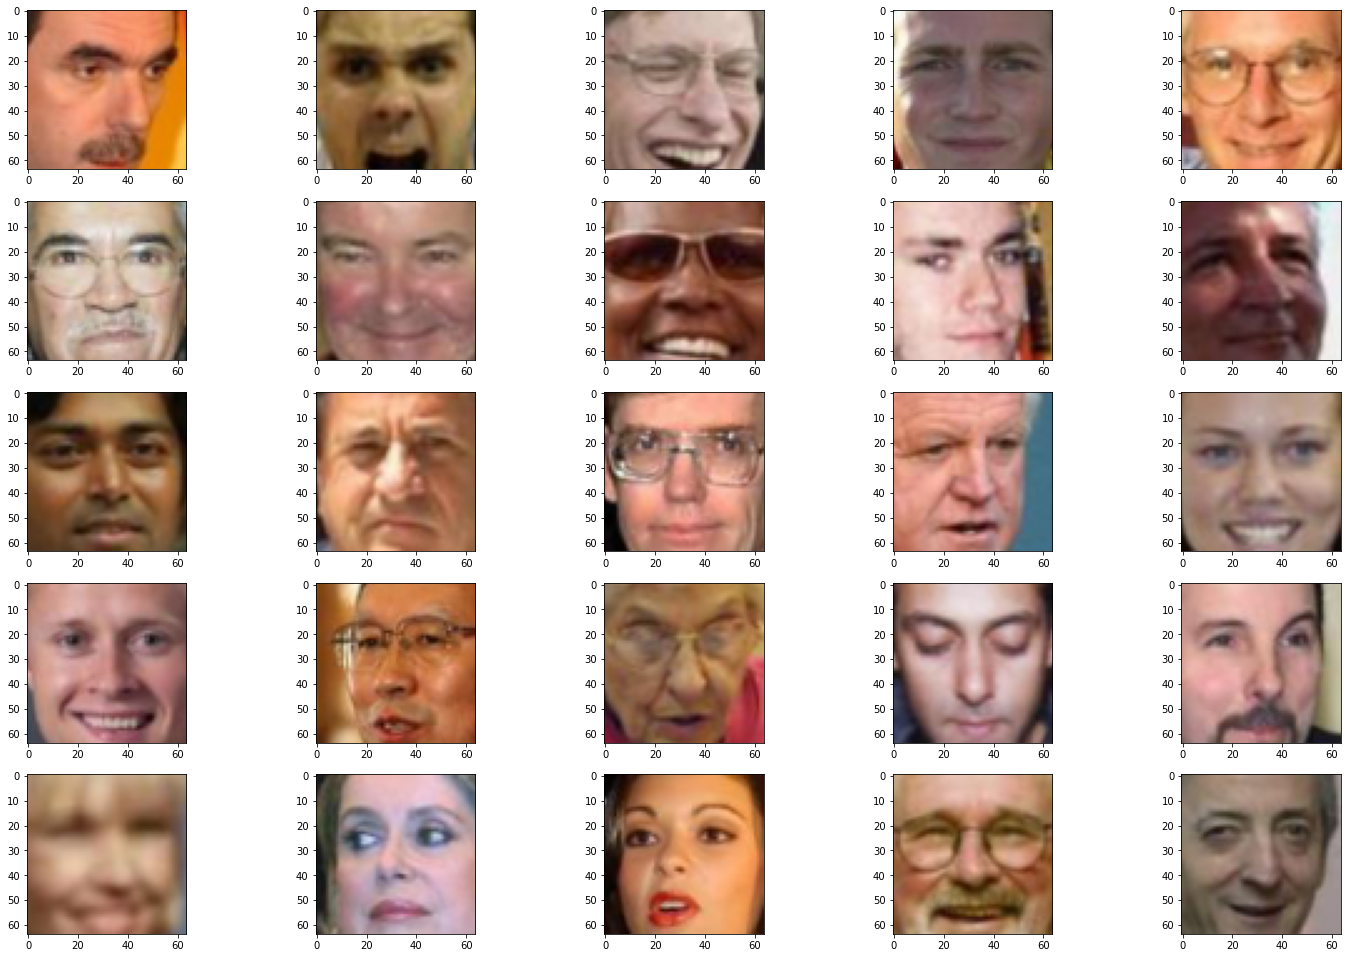

In [238]:
fig, ax = plt.subplots(5, 5, figsize=(25, 17))

for i in range(5):
  for j in range(5):
    id = np.random.randint(low=0, high=len(data))
    ax[i, j].imshow(data[id])

plt.show()

In [376]:
data = torch.FloatTensor(data)

In [377]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)

In [378]:
print(data.shape)
print(train_photos.shape)
print(val_photos.shape)

print(data.permute(0, 3, 1, 2).shape)

torch.Size([13143, 64, 64, 3])
torch.Size([11828, 64, 64, 3])
torch.Size([1315, 64, 64, 3])
torch.Size([13143, 3, 64, 64])


## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [405]:
dim_code = 100 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [456]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            #64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=0),
            #32
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=0),
            #16
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=0),
            # 8
            nn.Flatten(),
            nn.Linear(in_features=4096, out_features=dim_code)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=4096),
            
            nn.Unflatten(1, (64,8,8)),
            
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
            #nn.MaxUnpool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
            #nn.MaxUnpool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
            #nn.MaxUnpool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
        #'''
        
    def forward(self, x):
        #x = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)(x)
        #print(x.shape)
        x = x.float()
        latent_code = self.encoder(x)
        #print(latent_code.shape, "HERE")
        reconstruction = self.decoder(latent_code)
        #print(reconstruction.shape, "HERE2")
        reconstruction = torch.sigmoid(reconstruction)
        #<реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>
        
        return reconstruction, latent_code
      
    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 64, 64, 3)
        return generated

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x)
        return x

In [457]:
criterion = F.mse_loss

autoencoder = Autoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [458]:
train_loader = torch.utils.data.DataLoader(train_photos.permute(0, 3, 1, 2), batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos.permute(0, 3, 1, 2), batch_size=32)

In [460]:
#<тут Ваш код тренировки автоэнкодера>
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        #print(X_batch.shape)
        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(X_batch.to(device))
        reconstruction = reconstruction.view(-1, 3, 64, 64)
        loss = criterion(reconstruction, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstruction, latent_code = autoencoder(X_batch.to(device))
          reconstruction = reconstruction.view(-1, 3, 64, 64)
          loss = criterion(reconstruction, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    
    print(f'epoch = {epoch}, loss train = {train_losses[-1]}, loss val = {val_losses[-1]}')


<ipython-input-460-b3c82398e31f>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


epoch = 0, loss train = 0.013919520417127658, loss val = 0.007171634617926819
epoch = 1, loss train = 0.005320449036898444, loss val = 0.004613657315660801
epoch = 2, loss train = 0.00363251194043236, loss val = 0.0032778116375473993
epoch = 3, loss train = 0.003212882370713192, loss val = 0.002919048558743227
epoch = 4, loss train = 0.002888613708971723, loss val = 0.0029231504027155183
epoch = 5, loss train = 0.002696209040634032, loss val = 0.002740477355906651
epoch = 6, loss train = 0.0026663255166715465, loss val = 0.0028356952437510094
epoch = 7, loss train = 0.0025963393014830512, loss val = 0.0026361467483054313
epoch = 8, loss train = 0.0024698845280737088, loss val = 0.002748353101889647
epoch = 9, loss train = 0.002399068682869846, loss val = 0.0024057058589754717
epoch = 10, loss train = 0.002445209738043313, loss val = 0.002388743109934564



KeyboardInterrupt: 

In [ ]:
batch = np.ones((2, 4096))
batch = torch.FloatTensor(batch)
batch = nn.Unflatten(1, (64,8,8))(batch)
batch.shape

In [ ]:
batch = 

In [396]:
nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
print(batch.shape)
batch = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)(X_batch)
print(batch.shape)
batch = nn.ReLU()(batch)
batch = nn.MaxPool2d(kernel_size = 2, stride = 2)(batch)
print(batch.shape)
batch = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)(batch)
batch = nn.ReLU()(batch)
batch = nn.MaxPool2d(kernel_size = 2, stride = 2)(batch)
print(batch.shape)
batch = nn.Flatten()(batch)
batch = nn.Linear(in_features=16384, out_features=dim_code)(batch)
            
            
batch.shape

torch.Size([32, 3, 64, 64])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


torch.Size([32, 100])

In [340]:
#<тут Ваш код тренировки автоэнкодера>
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        print(X_batch.shape)
        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(X_batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(reconstruction, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstruction, latent_code = autoencoder(X_batch.to(device))
          reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(reconstruction, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    
    print(f'epoch = {epoch}, loss train = {train_losses[-1]}, loss val = {val_losses[-1]}')


<ipython-input-340-7234a7b81262>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


torch.Size([32, 3, 64, 64])



TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mtuple[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mtuple[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


In [472]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction, latent_code = autoencoder(batch.to(device))
      reconstruction = reconstruction.view(-1, 3, 64, 64)
      result = reconstruction.permute(0, 2, 3, 1).cpu().detach().numpy()
      ground_truth = batch.permute(0, 2, 3, 1).numpy()
      print(ground_truth.shape)
      print(result.shape)
      break

(32, 64, 64, 3)
(32, 64, 64, 3)


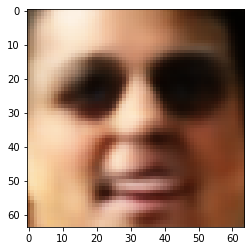

In [473]:
plt.imshow(result[0])

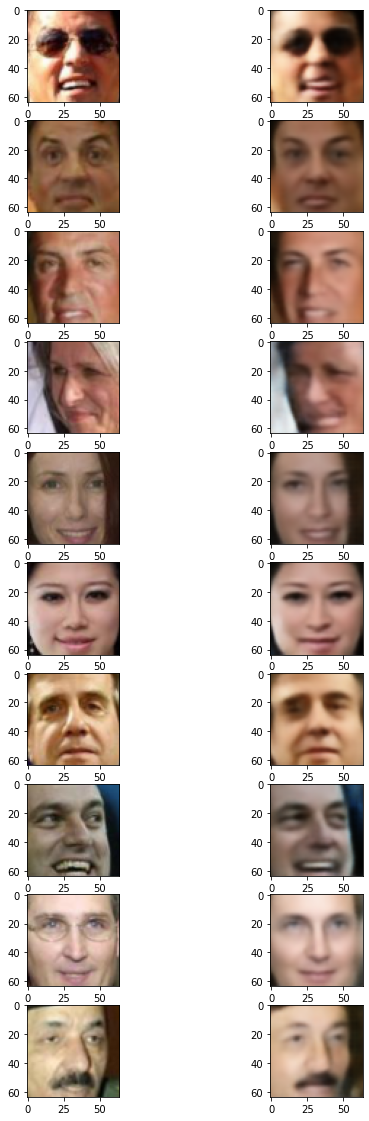

In [474]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:10], result[:10])):
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(10, 2, 2*i+2)
  plt.imshow(res)

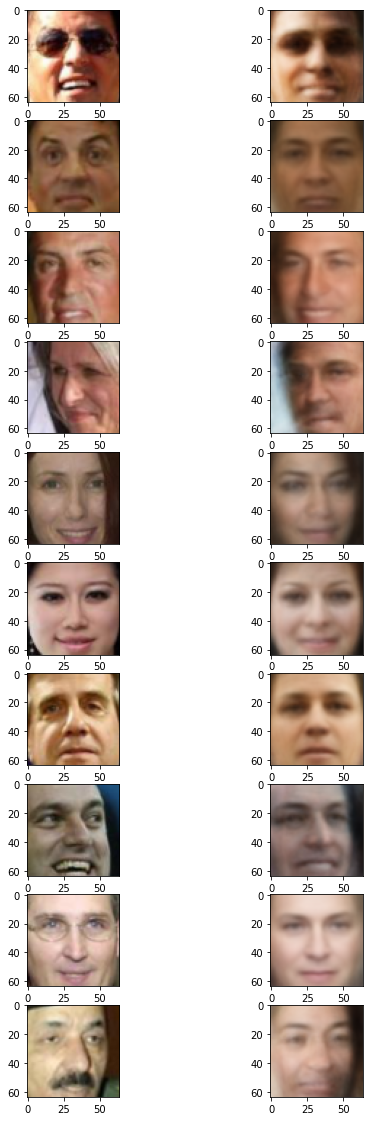

In [280]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:10], result[:10])):
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(10, 2, 2*i+2)
  plt.imshow(res)

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [497]:
smiling = attrs[attrs['Smiling'] > 2]

smiling['Smiling']

88       2.53044
108      2.55365
135       2.5625
136      2.03283
138      2.11501
          ...   
13034    2.78115
13063    2.05464
13065    2.02726
13085    2.11215
13104     2.0695
Name: Smiling, Length: 342, dtype: object

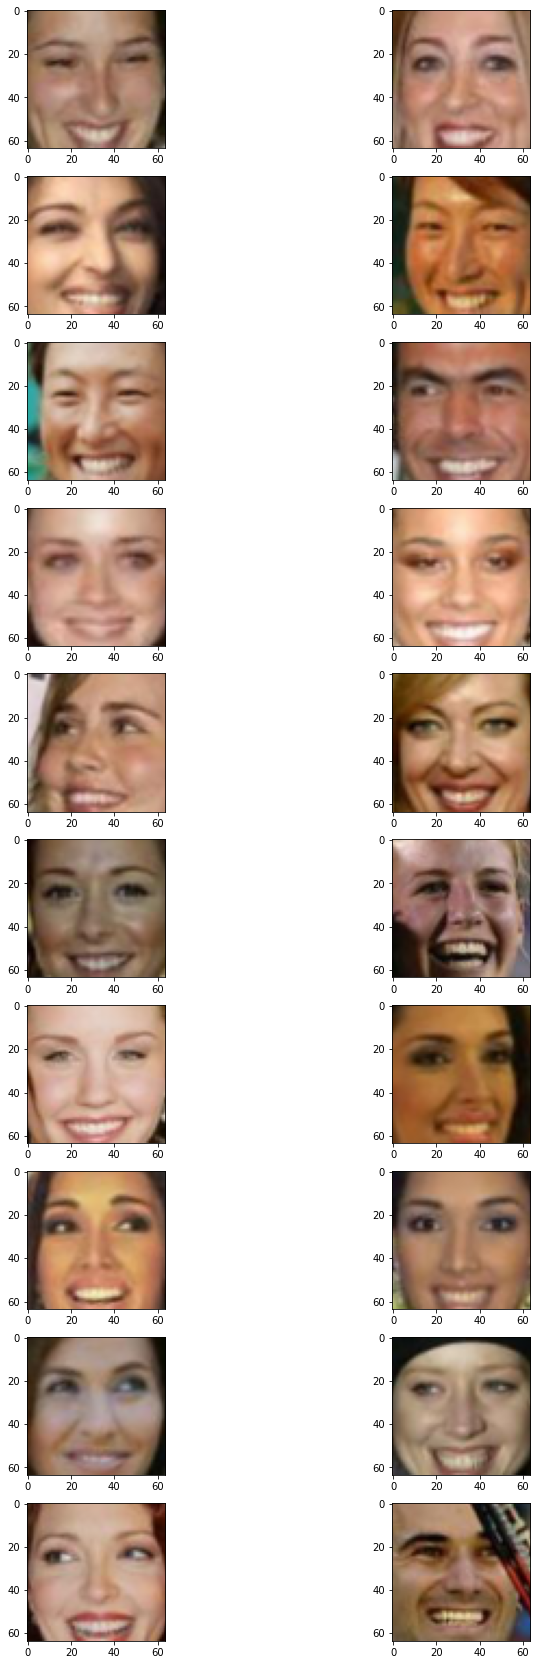

In [498]:
plt.figure(figsize=(12, 30))
for i in range(20):
  plt.subplot(10, 2, i + 1)
  plt.imshow(data[smiling.index[i]])

plt.show()

In [520]:
smiling.index[0]

smiling_latent_vectors = []

for i in range(15):
    id_person = smiling.index[i]
    x = torch.FloatTensor(data[id_person].reshape(1, 64, 64, 3)).permute(0, 3, 1, 2).to(device)
    #print(x.shape)
    #x = autoencoder.get_latent_vector(x)
    x = get_latent_vector(autoencoder, x)
    x = x.cpu().detach().numpy()
    smiling_latent_vectors.append(x)

In [521]:
not_smiling = attrs[attrs['Smiling'] < -2]

not_smiling['Smiling']

49      -2.30731
53      -2.02636
282     -2.04185
295     -2.24637
337     -2.01594
          ...   
12988   -2.06161
12989   -2.16162
12991   -2.34329
12992   -2.39269
13089   -2.12958
Name: Smiling, Length: 254, dtype: object

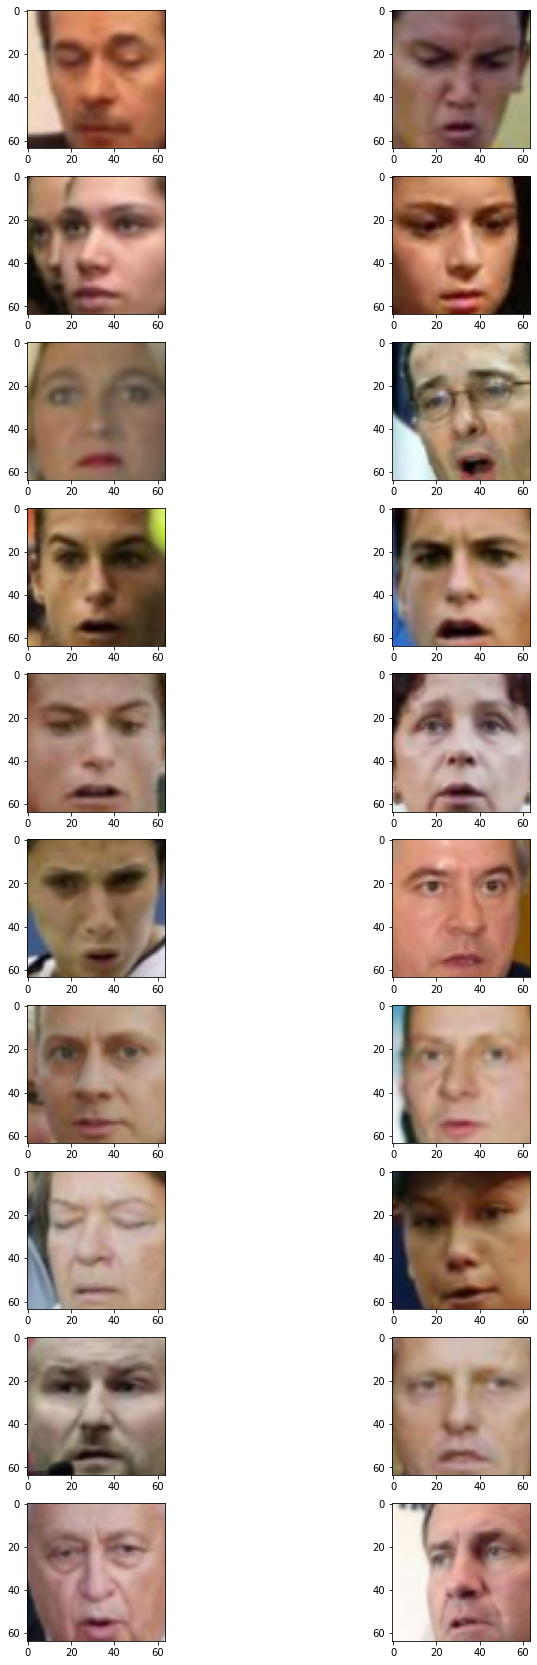

In [522]:
plt.figure(figsize=(12, 30))
for i in range(20):
  plt.subplot(10, 2, i + 1)
  plt.imshow(data[not_smiling.index[i]])

plt.show()

In [523]:
not_smiling_latent_vectors = []

for i in range(15):
    id_person = not_smiling.index[i]
    x = torch.FloatTensor(data[id_person].reshape(1, 64, 64, 3)).permute(0, 3, 1, 2).to(device)
    #print(x.shape)
    #x = autoencoder.get_latent_vector(x)
    x = get_latent_vector(autoencoder, x)
    x = x.cpu().detach().numpy()
    not_smiling_latent_vectors.append(x)

In [524]:
smile = np.mean(smiling_latent_vectors, axis=0) - np.mean(not_smiling_latent_vectors, axis=0)
smile.shape

(1, 100)

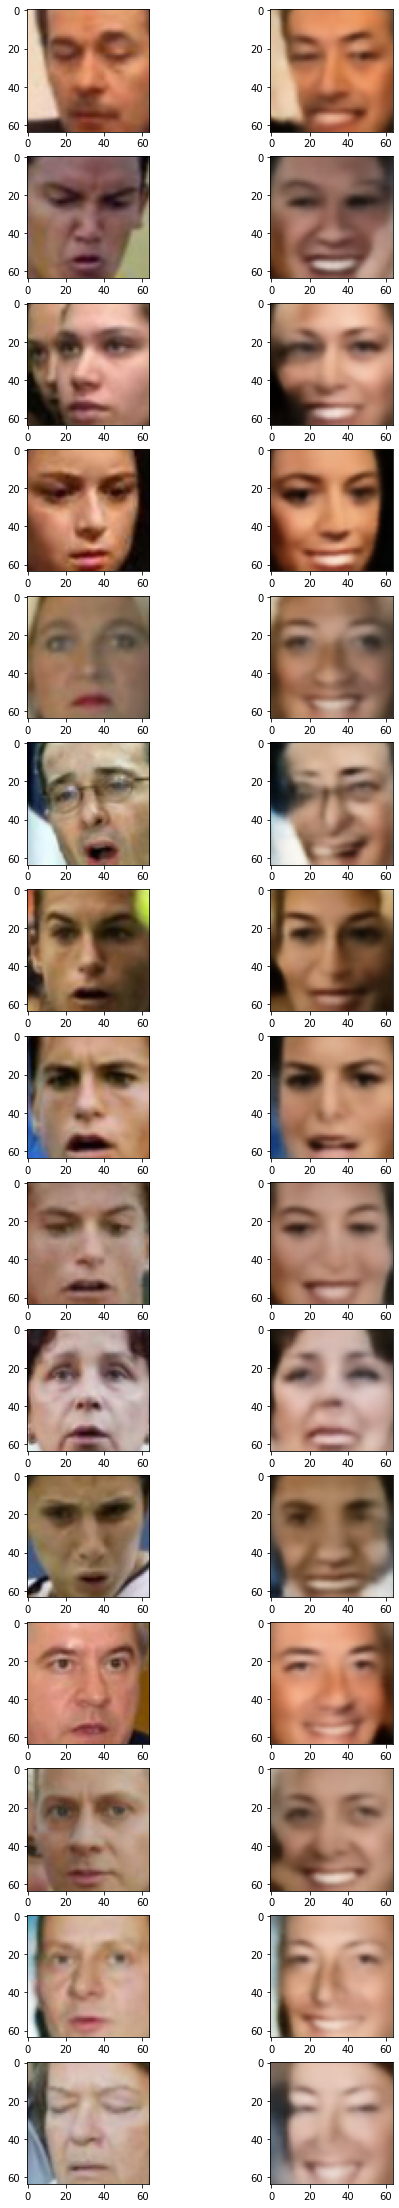

In [528]:
plt.figure(figsize=(8, 40))
for i in range(15):
  
  plt.subplot(15, 2, 2*i + 1)
  id_not_smiling = not_smiling.index[i]
  plt.imshow(data[id_not_smiling])
  
  plt.subplot(15, 2, 2*i + 2)
  latent = not_smiling_latent_vectors[i] + smile
  latent = torch.FloatTensor(latent).to(device)
  img = sample(autoencoder, latent)[0].cpu().detach().numpy()
  plt.imshow(img)

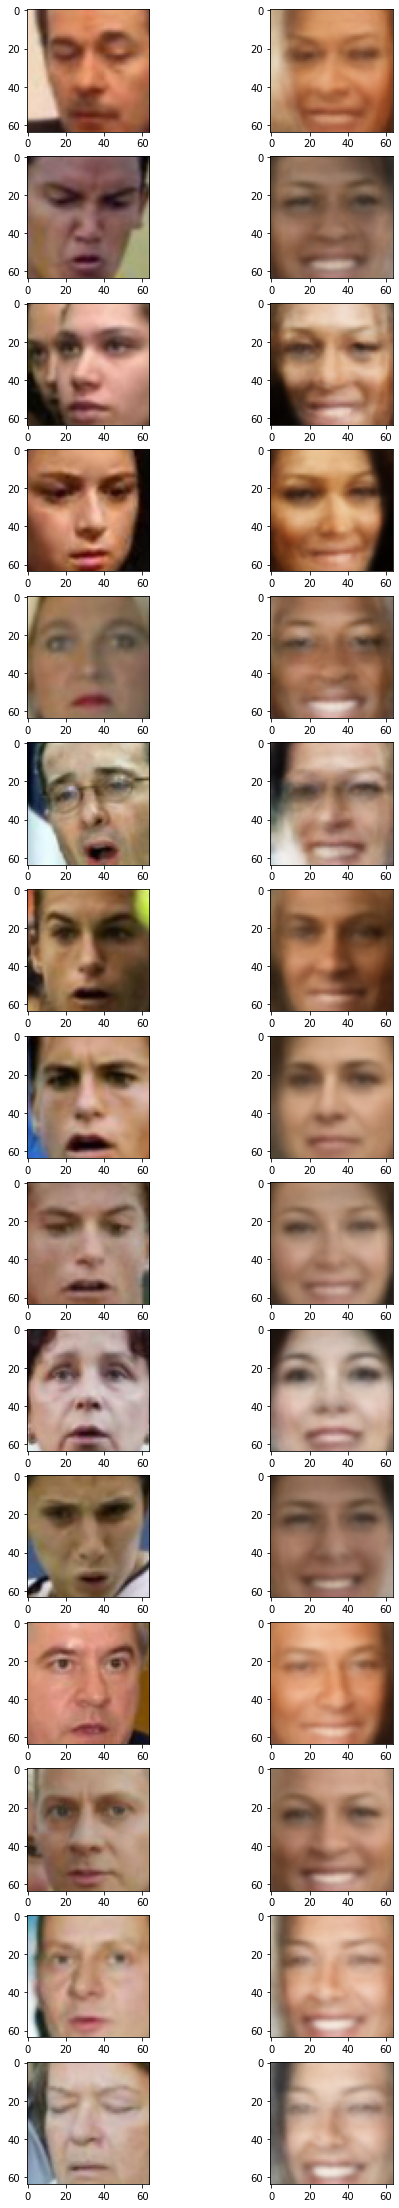

In [316]:
plt.figure(figsize=(8, 40))
for i in range(15):
  
  plt.subplot(15, 2, 2*i + 1)
  id_not_smiling = not_smiling.index[i]
  plt.imshow(data[id_not_smiling])
  
  plt.subplot(15, 2, 2*i + 2)
  latent = not_smiling_latent_vectors[i] + smile
  latent = torch.FloatTensor(latent).to(device)
  img = sample(autoencoder, latent)[0].cpu().detach().numpy()
  plt.imshow(img)

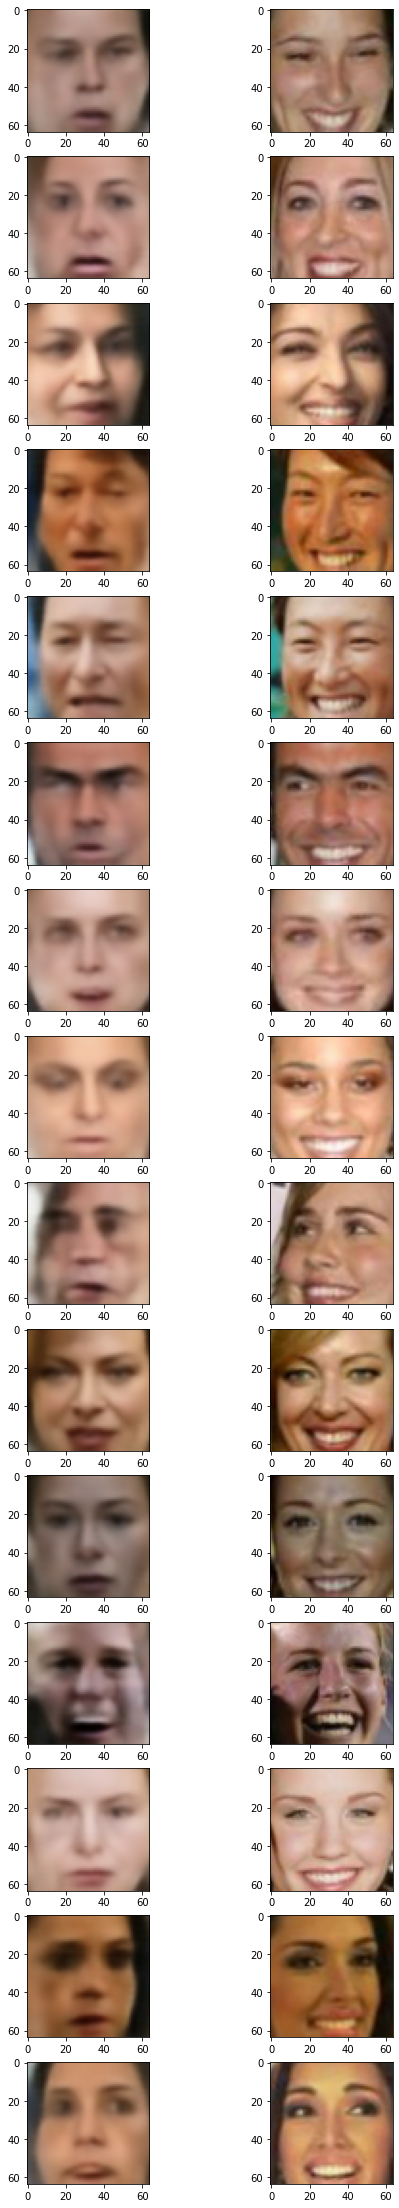

In [529]:
plt.figure(figsize=(8, 40))
for i in range(15):
  plt.subplot(15, 2, 2*i + 1)
  latent = smiling_latent_vectors[i] - smile
  latent = torch.FloatTensor(latent).to(device)
  img = sample(autoencoder, latent)[0].cpu().detach().numpy()
  plt.imshow(img)
  
  plt.subplot(15, 2, 2*i + 2)
  id_smiling = smiling.index[i]
  plt.imshow(data[id_smiling])

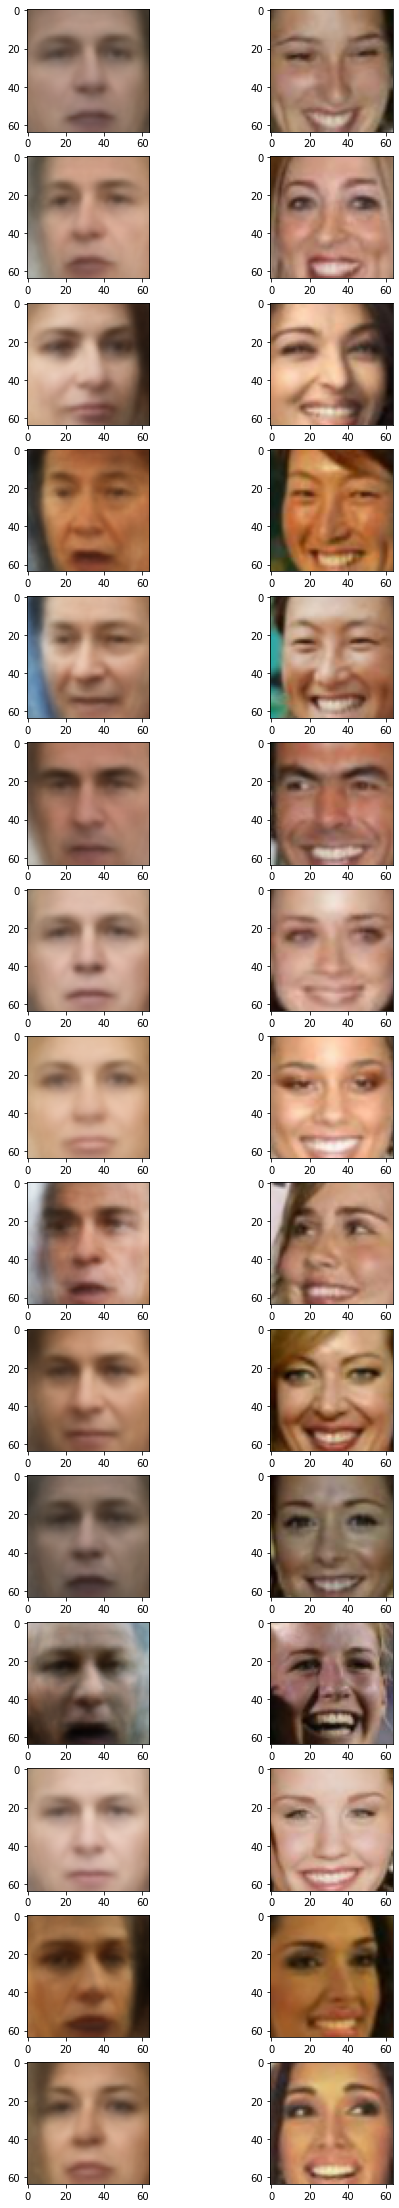

In [317]:
plt.figure(figsize=(8, 40))
for i in range(15):
  plt.subplot(15, 2, 2*i + 1)
  latent = smiling_latent_vectors[i] - smile
  latent = torch.FloatTensor(latent).to(device)
  img = sample(autoencoder, latent)[0].cpu().detach().numpy()
  plt.imshow(img)
  
  plt.subplot(15, 2, 2*i + 2)
  id_smiling = smiling.index[i]
  plt.imshow(data[id_smiling])

In [509]:
gt_0 = torch.FloatTensor([ground_truth[0]]).permute(0, 3, 1, 2).to(device)
gt_1 = torch.FloatTensor([ground_truth[1]]).permute(0, 3, 1, 2).to(device)

In [510]:
first_latent_vector = get_latent_vector(autoencoder, gt_0)
second_latent_vector = get_latent_vector(autoencoder, gt_1)

In [513]:
first_latent_vector.shape

torch.Size([1, 100])

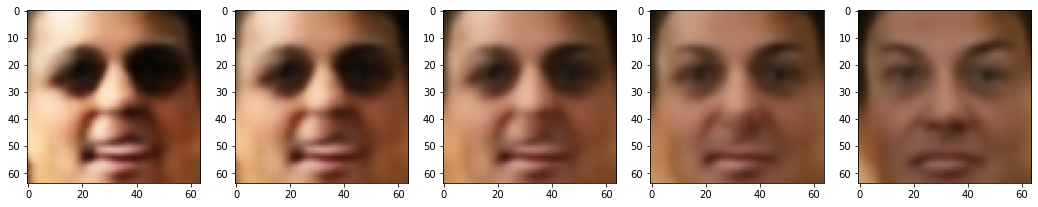

In [515]:
plt.figure(figsize=(18, 5))
for i, alpha in enumerate(np.linspace(0., 1., 5)):
  plt.subplot(1, 5, i + 1)
  latent = (1 - alpha) * first_latent_vector + alpha * second_latent_vector
  img = sample(autoencoder, latent)[0].cpu().detach().numpy()
  plt.imshow(img)

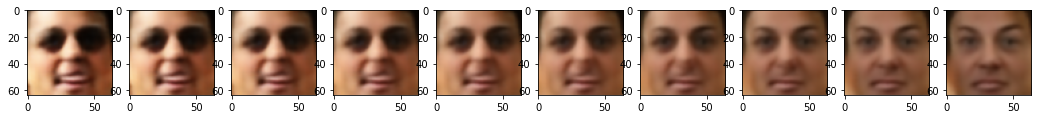

In [516]:
plt.figure(figsize=(18, 5))
for i, alpha in enumerate(np.linspace(0., 1., 10)):
  plt.subplot(1, 10, i + 1)
  latent = (1 - alpha) * first_latent_vector + alpha * second_latent_vector
  img = sample(autoencoder, latent)[0].cpu().detach().numpy()
  plt.imshow(img)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [703]:
from torchvision import transforms
from tqdm.notebook import tqdm

In [704]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [591]:
for batch in train_loader:
    x, y = batch
    print(x.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [641]:
dimension_code = 100

In [642]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=dimension_code*2)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dimension_code, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784)
        )
      
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
  
    def reparameterize(self, mu, logsigma):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * logsigma) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
      
    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, dimension_code)
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            x = self.reparameterize(mu, logsigma)
            return x
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        return reconstruction

    def forward(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, dimension_code)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance
        #z = self.reparameterize(mu, logsigma)
        z = self.gaussian_sampler(mu, logsigma)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [648]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    #loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    #loss = <binary cross-entropy>
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    #return <соедините тут две компоненты лосса. Mind the sign!>
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [649]:
criterion = loss_vae

vae_autoencoder = VAE()

optimizer = torch.optim.Adam(vae_autoencoder.parameters())

In [650]:
#<обучите модель на датасете MNIST>
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    vae_autoencoder.train()
    train_losses_per_epoch = []
    for batch_ in train_loader:
        batch, y = batch_
        optimizer.zero_grad()
        mu, logsigma, reconstruction = vae_autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    vae_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch_ in test_loader:
          batch, y = batch_
          mu, logsigma, reconstruction = vae_autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    
    print(f'epoch = {epoch+1}, loss train = {train_losses[-1]}, loss val = {val_losses[-1]}')

epoch = 1, loss train = 4908.04297578125, loss val = 3699.4809679512778
epoch = 2, loss train = 3870.362957552083, loss val = 3348.4935989136134
epoch = 3, loss train = 3639.514771875, loss val = 3253.552512074431
epoch = 4, loss train = 3558.413811848958, loss val = 3181.9550555049423
epoch = 5, loss train = 3515.7824424479168, loss val = 3147.7593604139624
epoch = 6, loss train = 3487.247029817708, loss val = 3156.242162929937
epoch = 7, loss train = 3464.524296223958, loss val = 3119.9330122585116
epoch = 8, loss train = 3448.627975390625, loss val = 3102.6622369053266
epoch = 9, loss train = 3437.4434010416667, loss val = 3113.812983991239
epoch = 10, loss train = 3427.051891015625, loss val = 3098.143741887979
epoch = 11, loss train = 3420.653581640625, loss val = 3094.689372784794
epoch = 12, loss train = 3411.6340278645835, loss val = 3084.470670754917
epoch = 13, loss train = 3405.8450057291666, loss val = 3077.6839697109626
epoch = 14, loss train = 3400.454854296875, loss val 

KeyboardInterrupt: 

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [651]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
vae_autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
      batch = batch[0]
      mu, logsigma, reconstruction = vae_autoencoder(batch.to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

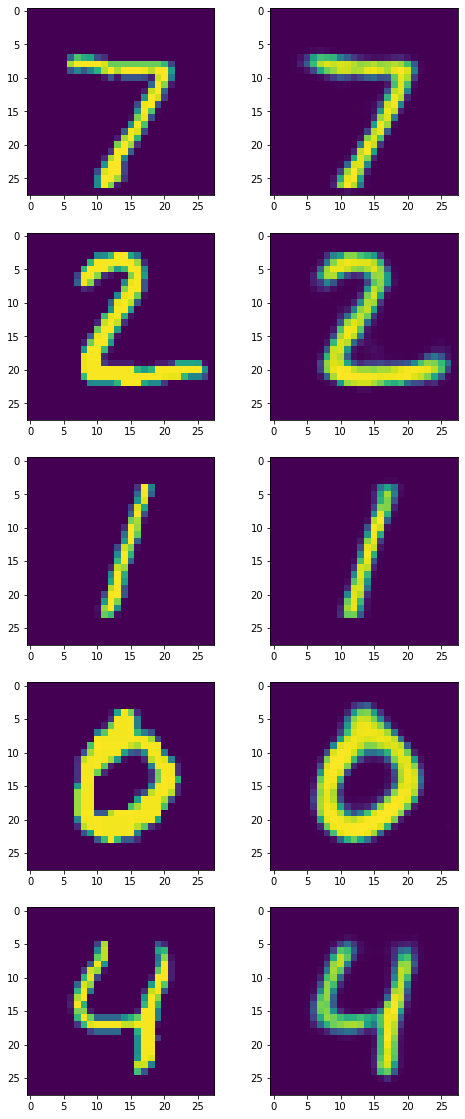

In [652]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  gt = gt.reshape(28, 28, 1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  res = res.reshape(28, 28, 1)
  plt.imshow(res)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [671]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
latent_vectors = []
colors = []

for batch_ in test_loader:
    batch, y = batch_
    mu, logsigma = vae_autoencoder.encode(batch.to(device))
    for x in mu:
        latent_vectors.append(x.cpu().detach().numpy())
    for col in y:
        colors.append(col)

latent_vectors = np.array(latent_vectors, dtype = np.float32)
colors = np.array(colors)

latent_vectors.shape

(10000, 100)

In [673]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(latent_vectors)

In [675]:
X_embedded.shape

(10000, 2)

In [679]:
# https://medium.com/nuances-of-programming/%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC-%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F-t-sne-%D0%BE%D1%82%D0%BB%D0%B8%D1%87%D0%BD%D1%8B%D0%B9-%D0%B8%D0%BD%D1%81%D1%82%D1%80%D1%83%D0%BC%D0%B5%D0%BD%D1%82-%D0%B4%D0%BB%D1%8F-%D1%81%D0%BD%D0%B8%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F-%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8-%D0%B2-python-f87af7eac9fe

import plotly.express as px
# Создание диаграммы разброса
fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 opacity=1, color=colors.astype(str))

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [787]:
dim_code_cvae = 10

In [788]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        
        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784 + 10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=dim_code_cvae*2)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code_cvae + 10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784)
        )
    
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        x = self.flatten(x).float()
        addz = torch.nn.functional.one_hot(torch.Tensor(class_num).long(), num_classes=10)
        x = torch.concat((x, addz), axis=1)
        x = self.encoder(x).view(-1, 2, dim_code_cvae)
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance
        return mu, logsigma, class_num
    
    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
      
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            x = self.reparameterize(mu, logsigma)
            return x
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        addz = torch.nn.functional.one_hot(torch.Tensor(class_num).long(), num_classes=10)
        z = torch.concat((z, addz), axis=1)
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        return reconstruction

    def forward(self, x):
        x, class_num = x[:, :-1], x[:, -1]
        mu, logsigma, class_num = self.encode(x, class_num)
        latent_vector = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent_vector, class_num)
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

In [789]:
criterion = loss_vae

cvae_autoencoder = CVAE()

optimizer = torch.optim.Adam(cvae_autoencoder.parameters())

In [790]:
#<обучите модель на датасете MNIST>
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    cvae_autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        x, y = batch
        y = y.reshape(len(y), 1)
        nx = torch.concat((nn.Flatten()(x), y), axis=1)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = cvae_autoencoder(nx.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(x.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    cvae_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          x, y = batch
          y = y.reshape(len(y), 1)
          nx = torch.concat((nn.Flatten()(x),y), axis=1)
          mu, logsigma, reconstruction = cvae_autoencoder(nx.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(x.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    
    print(f'epoch = {epoch+1}, loss train = {train_losses[-1]}, loss val = {val_losses[-1]}')

epoch = 1, loss train = 4517.250283333334, loss val = 3653.6912674096448
epoch = 2, loss train = 3734.663294921875, loss val = 3460.585738599491
epoch = 3, loss train = 3595.927943359375, loss val = 3351.9834109175317
epoch = 4, loss train = 3523.925646223958, loss val = 3322.1940137966753
epoch = 5, loss train = 3475.1641868489583, loss val = 3272.699259310104
epoch = 6, loss train = 3439.929038151042, loss val = 3242.781991781899
epoch = 7, loss train = 3414.3860059895833, loss val = 3221.2530958279253
epoch = 8, loss train = 3393.6005248697916, loss val = 3219.3331868229584
epoch = 9, loss train = 3374.410867578125, loss val = 3208.3756821117463
epoch = 10, loss train = 3359.81469921875, loss val = 3196.5696424782845
epoch = 11, loss train = 3345.86269375, loss val = 3184.454780164237
epoch = 12, loss train = 3333.4551596354167, loss val = 3177.9454688904
epoch = 13, loss train = 3323.520390234375, loss val = 3152.7978890025956
epoch = 14, loss train = 3313.538138671875, loss val = 

KeyboardInterrupt: 

In [791]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
cvae_autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
      x, y = batch
      y = y.reshape(len(y), 1)
      nx = torch.concat((nn.Flatten()(x),y), axis=1)
      mu, logsigma, reconstruction = cvae_autoencoder(nx.to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = x.numpy()
      break

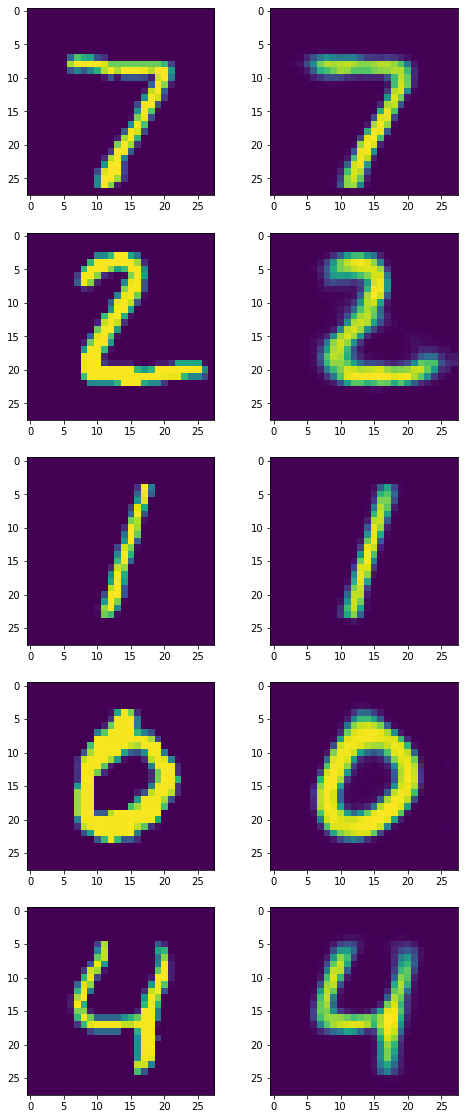

In [792]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  gt = gt.reshape(28, 28, 1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  res = res.reshape(28, 28, 1)
  plt.imshow(res)

In [748]:
a = torch.nn.functional.one_hot(torch.Tensor([3, 3, 3]).long(), num_classes=10)
print(a)

b = torch.Tensor([[1], [2], [3]])
print(b)

c = torch.concat((a, b), axis=1)
print(c)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
tensor([[1.],
        [2.],
        [3.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3.]])


In [ ]:
b = np.tensor

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

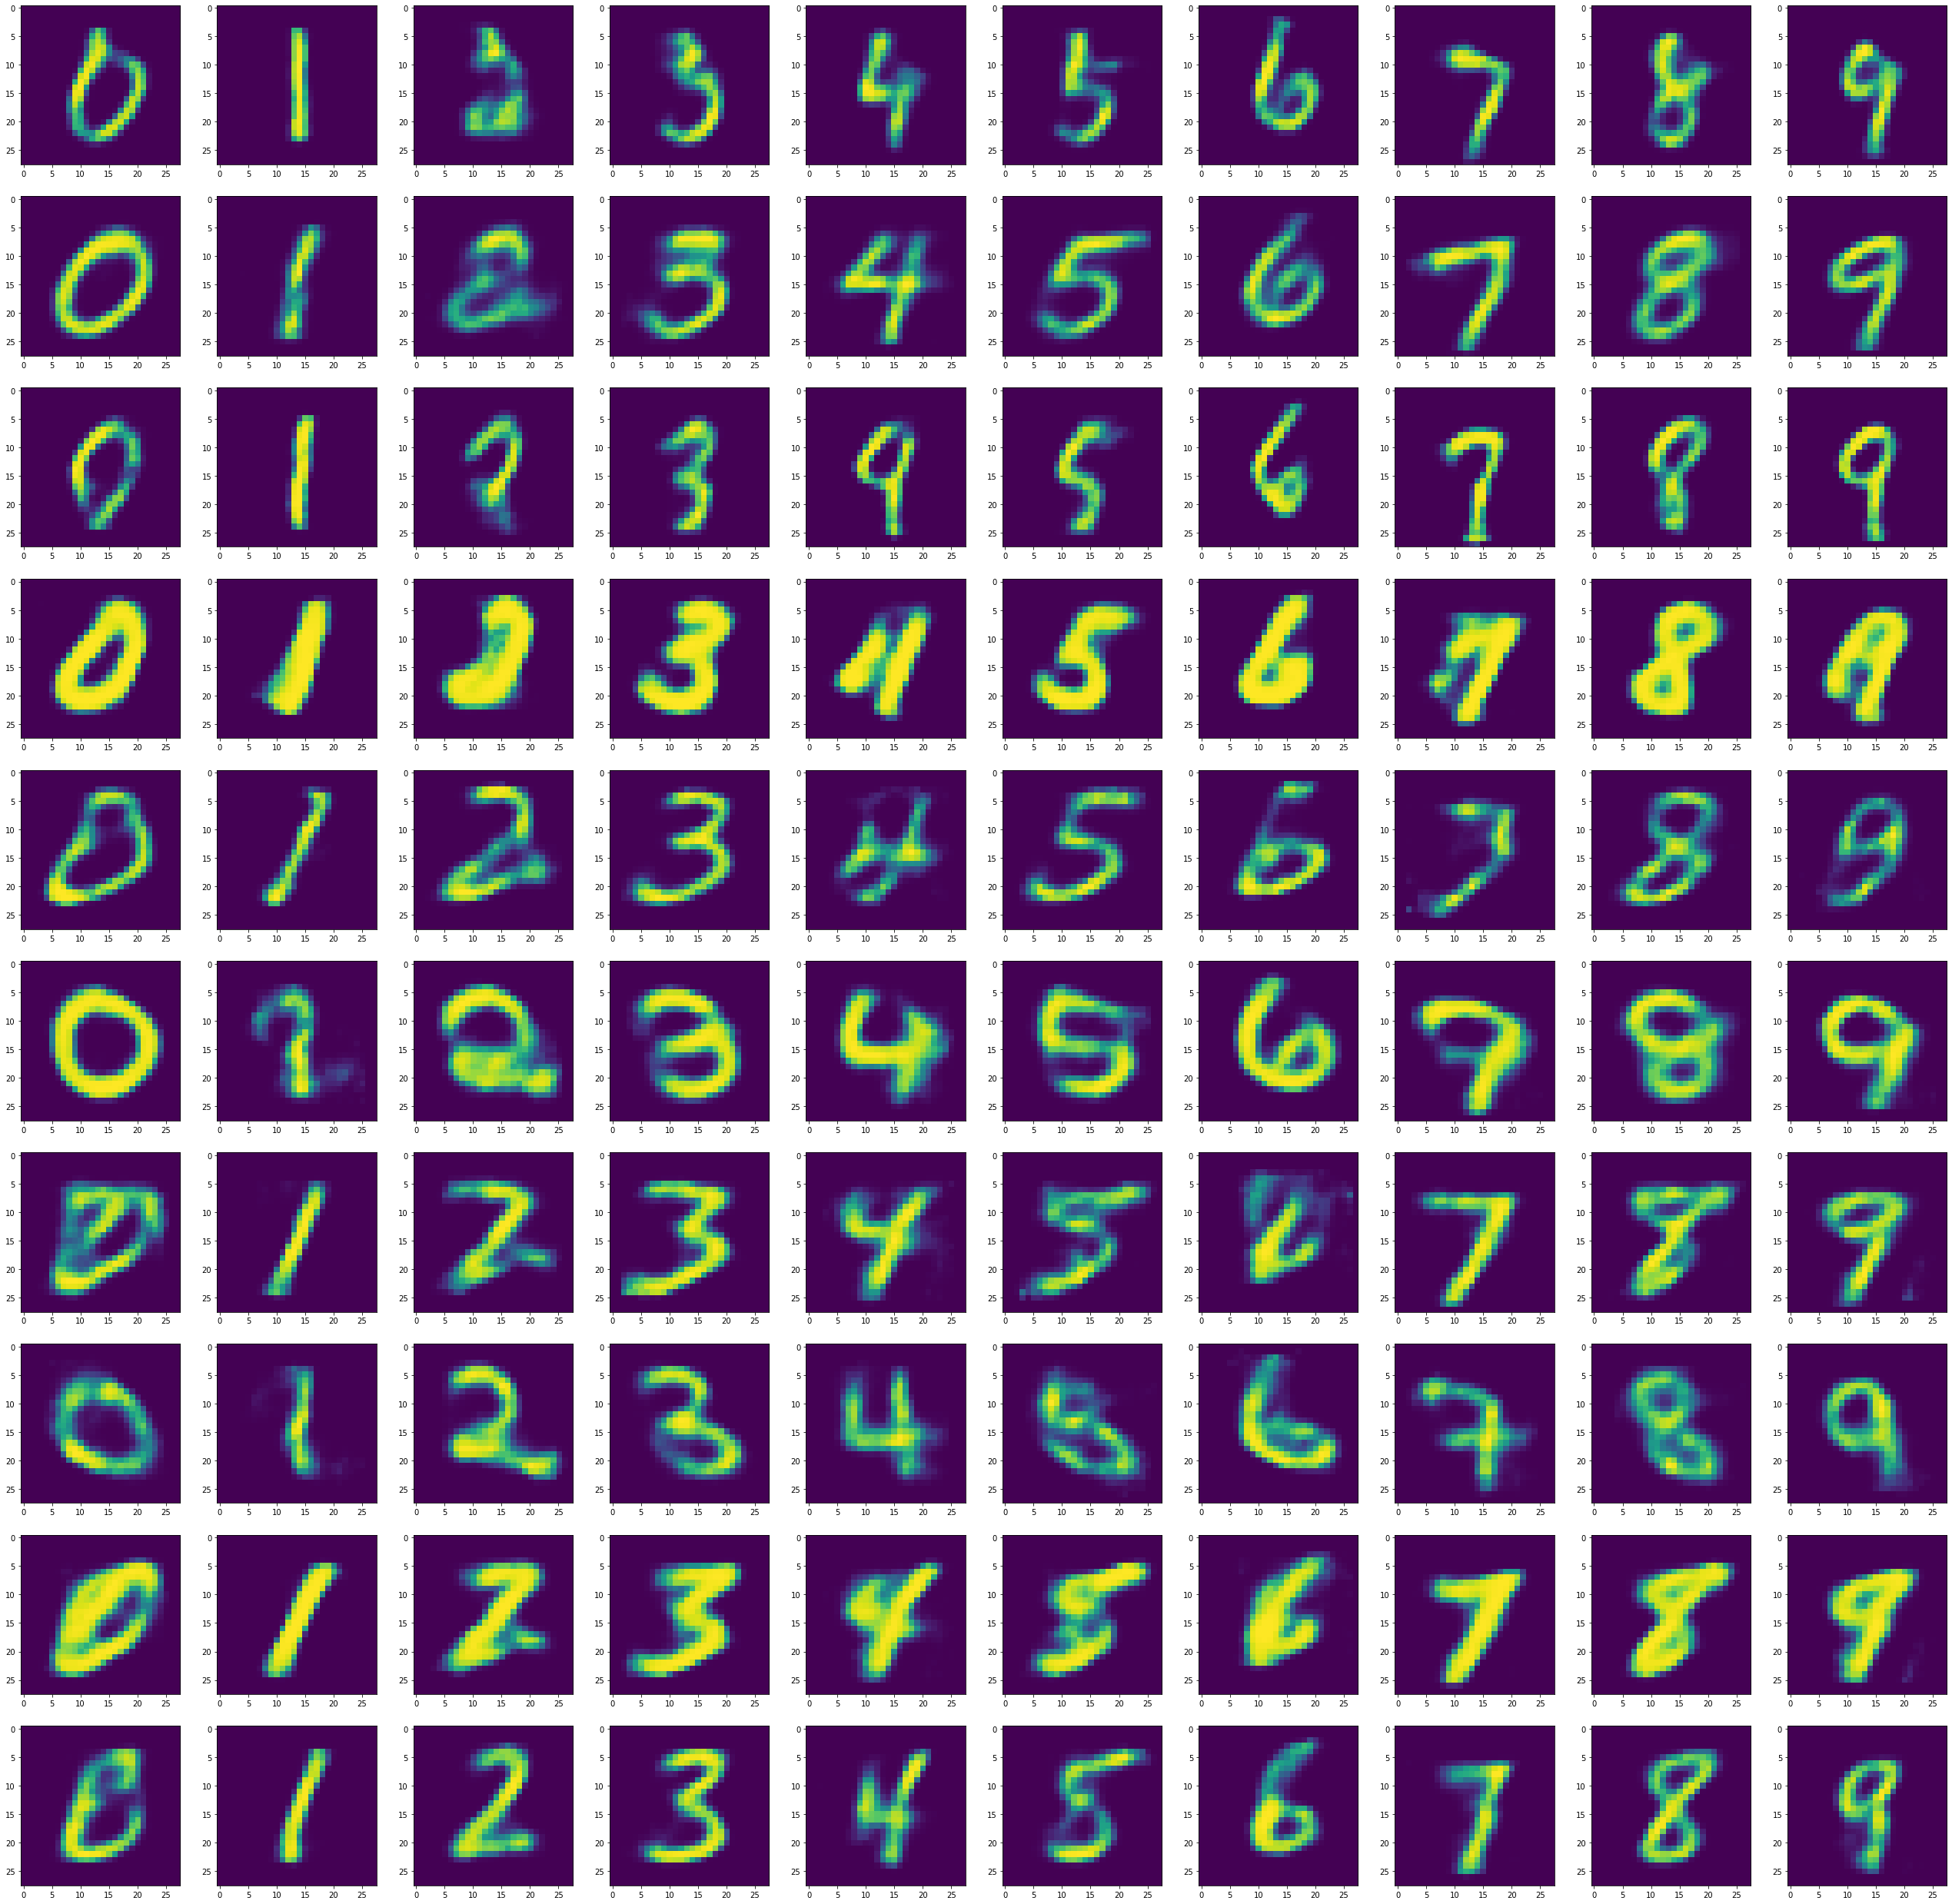

In [805]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code_cvae) for i in range(10)])
#nz = np.random.randint(low=0, high = 10, size=(10))

z = torch.FloatTensor(z)
#nz = torch.FloatTensor(nz)
#nz = torch.nn.functional.one_hot(torch.Tensor(nz).long(), num_classes=10)
#print(z.shape, nz.shape)
#z = torch.concat((z, nz), axis=1)

#output = cvae_autoencoder.decode(z.to(device), nz.to(device))
#print(output.shape)

plt.figure(figsize=(45, 45))
for i in range(10):
    for j in range(10):
        give1 = z[i].reshape(1, dim_code_cvae)
        give2 = [j]
        #print(give1.shape)
        #give1 = torch.FloatTensor(give1)
        give2 = torch.FloatTensor(give2)
        #print(give2)
        zi = cvae_autoencoder.decode(give1.to(device), give2.to(device))
        zi = zi.cpu().detach().numpy().reshape(28, 28, 1)
        plt.subplot(10, 10, i*10 + j + 1)

        #zi = output[i].cpu().detach().numpy().reshape(28, 28, 1)
        plt.imshow(zi)

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [807]:
latent_vectors = []
colors = []

for batch in test_loader:
    x, y = batch
    #print(x.shape,  y.shape)
    mu, logsigma, y = cvae_autoencoder.encode(x.to(device), y.to(device))
    for x in mu:
        latent_vectors.append(x.cpu().detach().numpy())
    for col in y:
        colors.append(col)

latent_vectors = np.array(latent_vectors, dtype = np.float32)
colors = np.array(colors)

latent_vectors.shape

(10000, 10)

In [785]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(latent_vectors)

X_embedded.shape

(10000, 2)

In [ ]:
Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.

Итак, план:

Получить латентные представления картинок тестового датасета
Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам разных цифр.

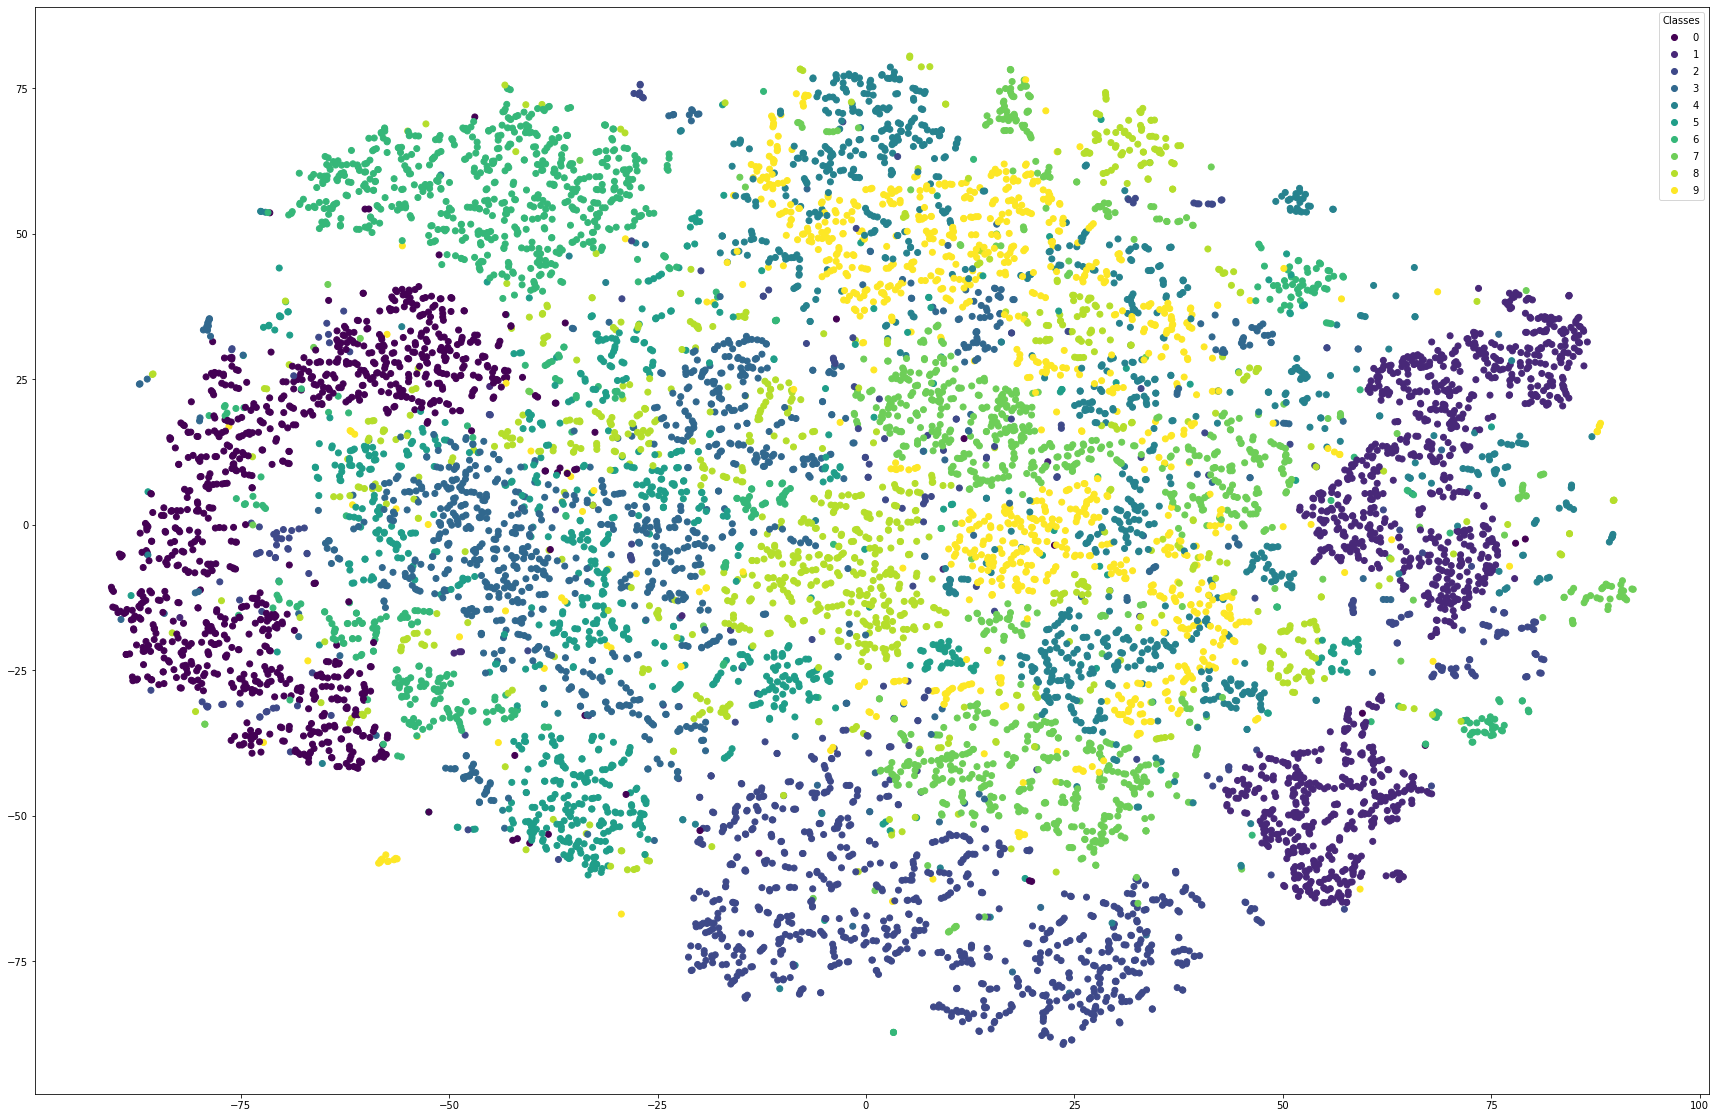

In [842]:
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
  
fig, ax = plt.subplots(figsize=(30, 20))

scatter = ax.scatter(x=X_embedded[:,0], y=X_embedded[:,1], 
                 c = colors, label = colors, cmap='viridis')

ax.legend(*scatter.legend_elements(), title="Classes")

plt.show()